In [1]:
from collections import defaultdict
from benchmark_utils import *

In [2]:
n = 100
m = 100
density = 0.1  # Probability of observing each entry

# seed
seed = int(time.time())

# Generate synthetic problem
X_true, X_obs, mask, u_true, v_true = generate_synthetic_problem(m, n, density,
                                                                 seed - 1)  # seed-1 to avoid overlap with the gaussian initialization seed as they'd be the same otherwise

In [3]:
# Baseline using Truncated SVD with imputed values
print("\n=== Truncated SVD ===")
observed_error_svd, full_error_svd, time_svd = baseline_svd_numpy(X_true, X_obs, mask)
print(f"SVD: Observed Error={observed_error_svd:.6f}, Full Error={full_error_svd:.6f}, Time={time_svd:.4f}s")


=== Truncated SVD ===
SVD: Observed Error=32.231798, Full Error=109.094655, Time=0.0193s


=== Gaussian Initialization ===
=== Alternating Optimization (ALS) ===
ALS: Residual=1.557090, Observed Error=1.55709040, Full Error=9.53555406, Iter=14, Time=0.0546s

=== ALS with Normalization (NormALS) ===
NormALS: Residual=4.347381, Observed Error=4.34738122, Full Error=20.42710597, Iter=10, Time=0.0358s

=== Gradient Descent (GD) ===
GD: Residual=175.270027, Observed Error=3.00079483, Full Error=16.53313670, Iter=324, Time=0.0408s


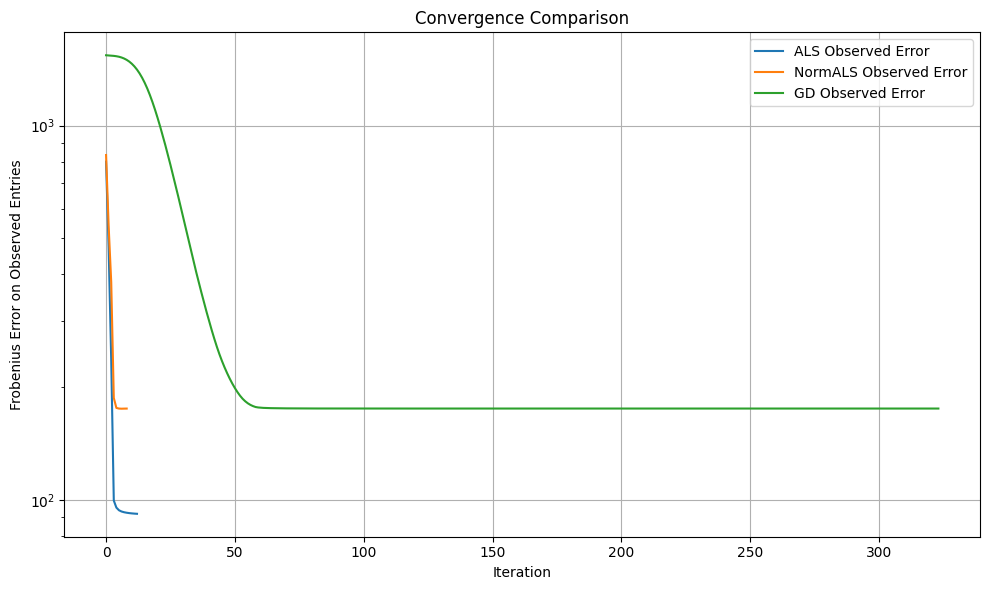

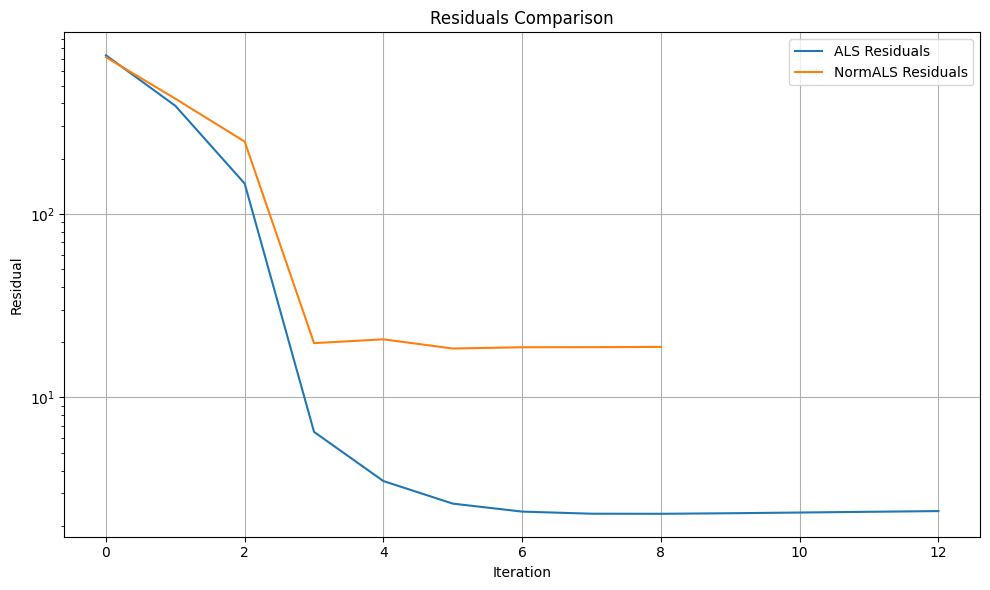

In [4]:
# Benchmark the different initialization strategies
print("=== Gaussian Initialization ===")
u0_g, v0_g = initialize_uv(X_obs, mask, strategy='gaussian', seed=seed)
# Benchmark the different solvers
gauss = compare_solvers(X_obs, X_true, u0_g.copy(), v0_g.copy(), mask, plot=True, gd_params=[9e-3, 7.94e-01],
                        max_it=5000, patience=3)


=== SVD Initialization ===
=== Alternating Optimization (ALS) ===
ALS: Residual=0.000000, Observed Error=0.00000016, Full Error=0.00000104, Iter=51, Time=0.1414s

=== ALS with Normalization (NormALS) ===
NormALS: Residual=0.000000, Observed Error=0.00000005, Full Error=0.00000032, Iter=52, Time=0.1439s

=== Gradient Descent (GD) ===
GD: Residual=0.000003, Observed Error=0.00041822, Full Error=0.00420598, Iter=345, Time=0.0278s


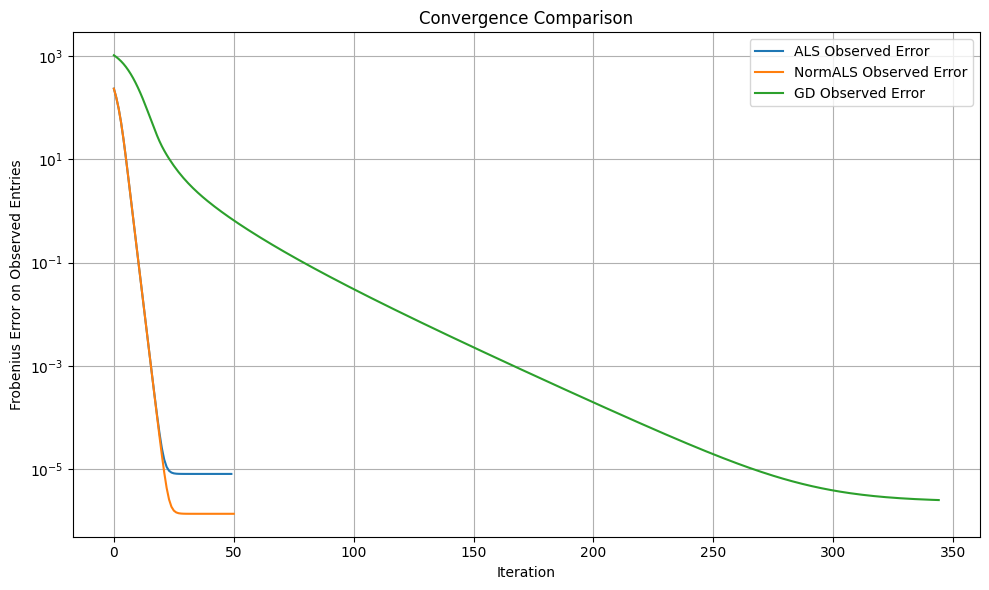

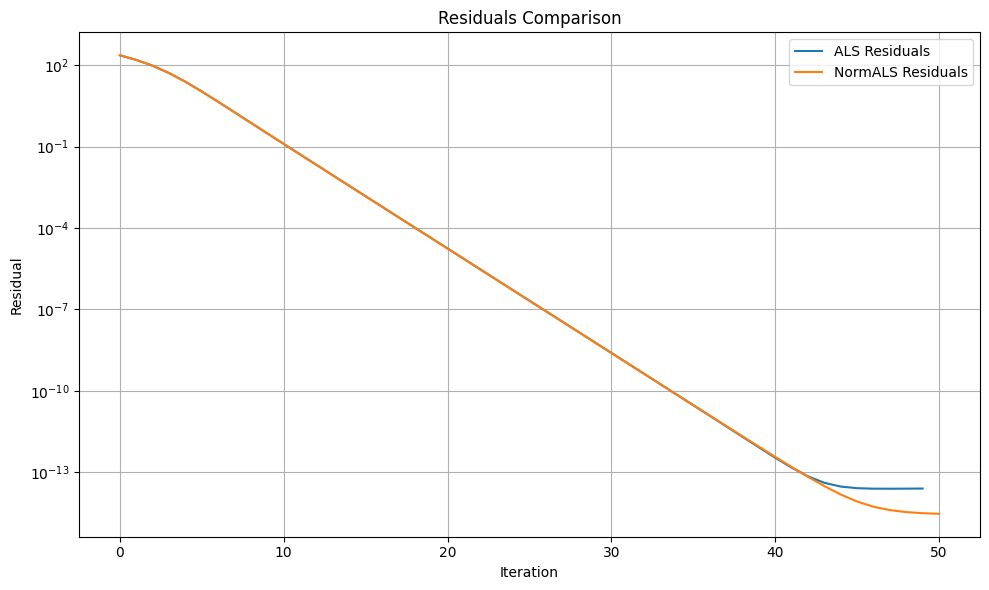

In [5]:
print("\n=== SVD Initialization ===")
u0_s, v0_s = initialize_uv(X_obs, mask, strategy='svd', seed=seed)
svd = compare_solvers(X_obs, X_true, u0_s.copy(), v0_s.copy(), mask, lambda_als=[1e-8, 1e-10], gd_params=[1e-02, 1e-08],
                      plot=True, max_it=5000, patience=3)


=== SVD + Noise Initialization ===
=== Alternating Optimization (ALS) ===
ALS: Residual=0.000000, Observed Error=0.00000033, Full Error=0.00000218, Iter=48, Time=0.1404s

=== ALS with Normalization (NormALS) ===
NormALS: Residual=0.000000, Observed Error=0.00000005, Full Error=0.00000032, Iter=51, Time=0.1487s

=== Gradient Descent (GD) ===
GD: Residual=0.000002, Observed Error=0.00029124, Full Error=0.00292960, Iter=201, Time=0.0140s


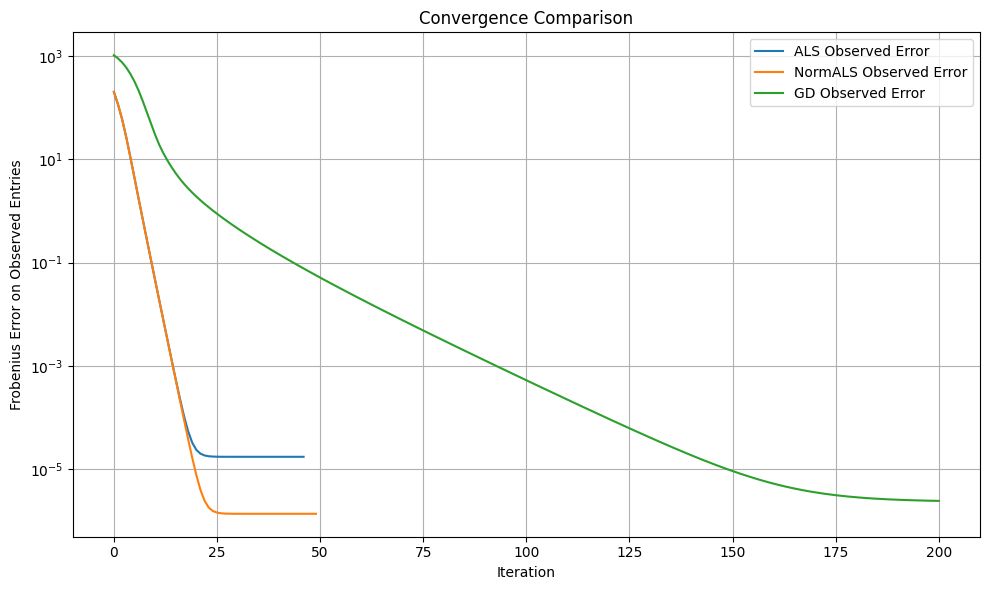

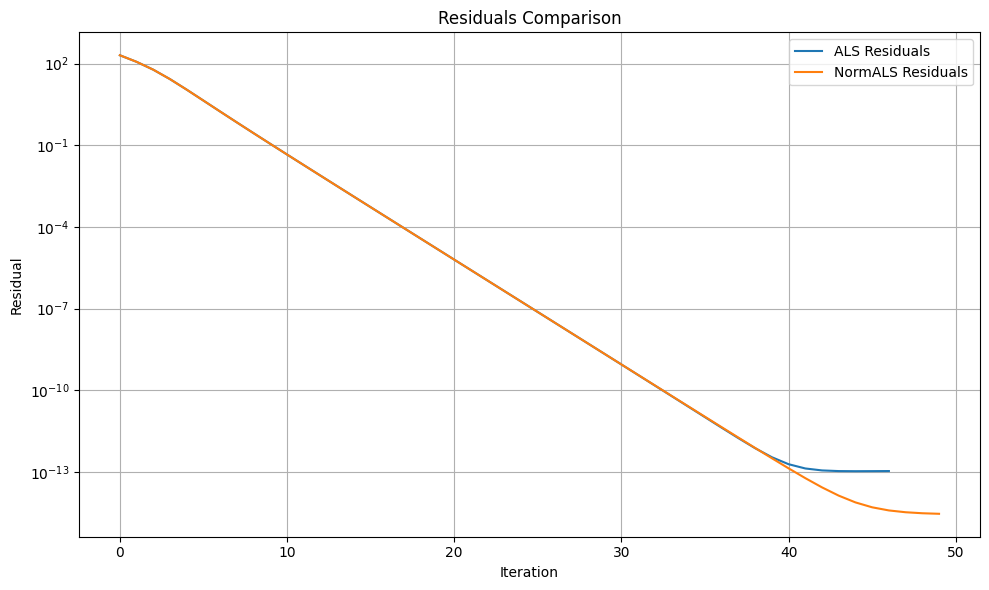

In [6]:
print("\n=== SVD + Noise Initialization ===")
u0_sn, v0_sn = initialize_uv(X_obs, mask, strategy='svd', epsilon=0.1, seed=seed)
svd_n = compare_solvers(X_obs, X_true, u0_sn.copy(), v0_sn.copy(), mask, lambda_als=[3e-8, 1e-10],
                        gd_params=[1.78e-02, 1e-8], plot=True, max_it=5000, patience=3)


=== Mean Initialization ===
=== Alternating Optimization (ALS) ===
ALS: Residual=3.693003, Observed Error=3.69300329, Full Error=19.60059596, Iter=68, Time=0.1955s

=== ALS with Normalization (NormALS) ===
NormALS: Residual=10.975219, Observed Error=10.97521892, Full Error=263.86607003, Iter=10, Time=0.0325s

=== Gradient Descent (GD) ===
GD: Residual=727.358011, Observed Error=26.95957074, Full Error=156.89641072, Iter=5000, Time=0.3965s


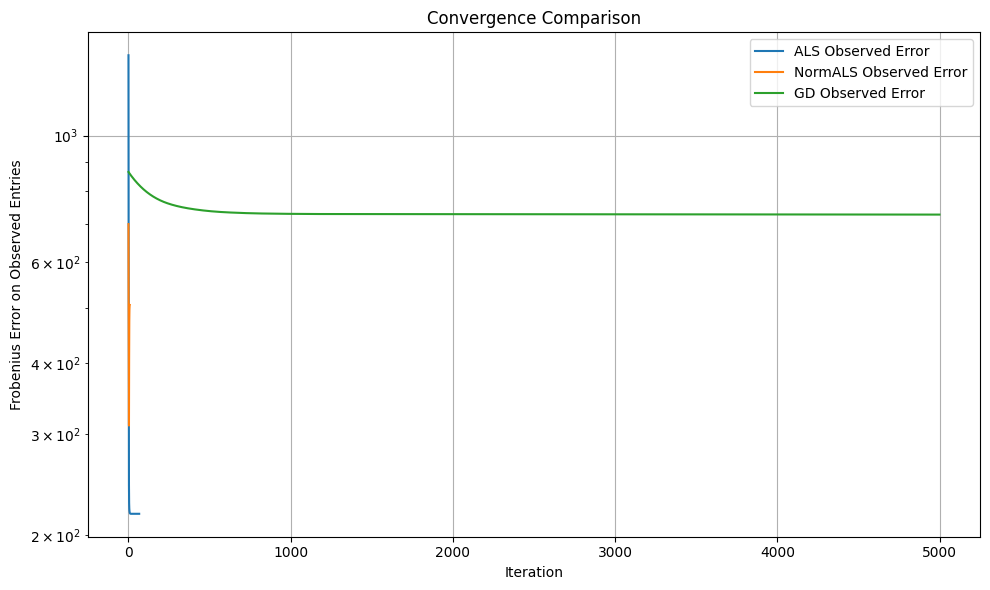

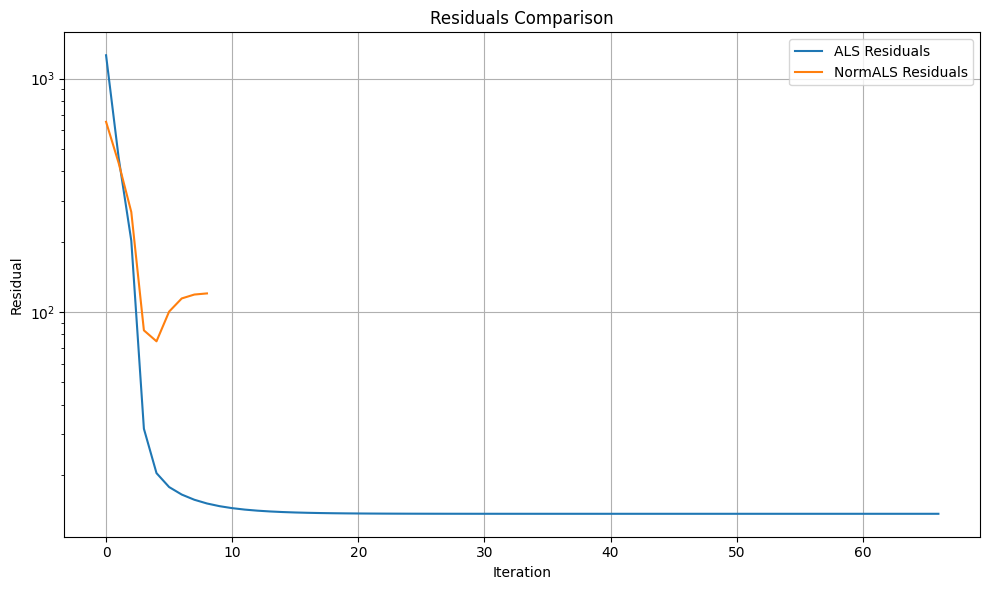

In [7]:
print("\n=== Mean Initialization ===")
u0_m, v0_m = initialize_uv(X_obs, mask, strategy='mean', seed=seed)
mean = compare_solvers(X_obs, X_true, u0_m.copy(), v0_m.copy(), mask, lambda_als=[1e-0, 5.80e-03],
                       gd_params=[1.78e-05, 5.62e-05], plot=True, max_it=5000, patience=3)

In [8]:
# compare the results of the different initializations and solvers in a table

# Create a DataFrame to store the results
results_ALS = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['ALS']['observed_error'],
        svd['ALS']['observed_error'],
        svd_n['ALS']['observed_error'],
        mean['ALS']['observed_error']
    ],
    'Full Error': [
        gauss['ALS']['full_error'],
        svd['ALS']['full_error'],
        svd_n['ALS']['full_error'],
        mean['ALS']['full_error']
    ],
    'Time': [
        gauss['ALS']['time'],
        svd['ALS']['time'],
        svd_n['ALS']['time'],
        mean['ALS']['time']
    ]
})
# Convert the DataFrame to a string table
table_str = tabulate(results_ALS, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Alternating Optimization (ALS) ===")
print(table_str)

results_NormALS = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['NormALS']['observed_error'],
        svd['NormALS']['observed_error'],
        svd_n['NormALS']['observed_error'],
        mean['NormALS']['observed_error']
    ],
    'Full Error': [
        gauss['NormALS']['full_error'],
        svd['NormALS']['full_error'],
        svd_n['NormALS']['full_error'],
        mean['NormALS']['full_error']
    ],
    'Time': [
        gauss['NormALS']['time'],
        svd['NormALS']['time'],
        svd_n['NormALS']['time'],
        mean['NormALS']['time']
    ]
})

# Convert the DataFrame to a string table
table_str = tabulate(results_NormALS, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Alternating Optimization with Normalization (NormALS) ===")
print(table_str)

results_gd = pd.DataFrame({
    'Method': ['Gaussian', 'SVD', 'SVD + Noise', 'Mean'],
    'Observed Error': [
        gauss['GD']['observed_error'],
        svd['GD']['observed_error'],
        svd_n['GD']['observed_error'],
        mean['GD']['observed_error']
    ],
    'Full Error': [
        gauss['GD']['full_error'],
        svd['GD']['full_error'],
        svd_n['GD']['full_error'],
        mean['GD']['full_error']
    ],
    'Time': [
        gauss['GD']['time'],
        svd['GD']['time'],
        svd_n['GD']['time'],
        mean['GD']['time']
    ]
})
# Convert the DataFrame to a string table
table_str = tabulate(results_gd, headers='keys', tablefmt='pretty', showindex=False)
# Print the table
print("=== Gradient Descent (GD) ===")
print(table_str)


=== Alternating Optimization (ALS) ===
+-------------+------------------------+-----------------------+---------------------+
|   Method    |     Observed Error     |      Full Error       |        Time         |
+-------------+------------------------+-----------------------+---------------------+
|  Gaussian   |   1.5570904026640968   |   9.535554058913357   | 0.05455374717712402 |
|     SVD     | 1.5711898233270213e-07 | 1.035617942294034e-06 | 0.14142727851867676 |
| SVD + Noise | 3.2819246946679624e-07 | 2.178152697209171e-06 | 0.14037275314331055 |
|    Mean     |   3.6930032916651045   |  19.600595962903295   | 0.19553852081298828 |
+-------------+------------------------+-----------------------+---------------------+
=== Alternating Optimization with Normalization (NormALS) ===
+-------------+------------------------+------------------------+----------------------+
|   Method    |     Observed Error     |       Full Error       |         Time         |
+-------------+----------

# Benchmarking over 50 seeds

In [9]:
init_settings = {
    'gaussian': {
        'lambda_als': [0.403, 1.5e-2],
        'gd_params': [9e-3, 7.94e-01]
    },
    'svd': {
        'lambda_als': [1e-8, 1e-10],
        'gd_params': [1.78e-02, 1e-08]
    },
    'svd+noise': {
        'lambda_als': [3e-8, 1e-10],
        'gd_params': [1e-02, 1e-8]
    },
    'mean': {
        'lambda_als': [1e-0, 5.80e-03],
        'gd_params': [1.78e-05, 5.62e-05]
    }
}

## Baseline using Truncated SVD

In [10]:
# baseline using Truncated SVD with imputed values over 20 seeds
svd_observed_errors = []
svd_full_errors = []
for seed in range(50):
    X_true, X_obs, mask, u_true, v_true = generate_synthetic_problem(m, n, density,
                                                                     seed)
    observed_error_svd, full_error_svd, time_svd = baseline_svd(X_true, X_obs, mask)
    svd_observed_errors.append(observed_error_svd)
    svd_full_errors.append(full_error_svd)

# Convert the results to a DataFrame for better visualization
svd_results = pd.DataFrame({
    'Observed Error': svd_observed_errors,
    'Full Error': svd_full_errors,
})
print("=== Truncated SVD Results (mean over 20 seeds) ===")
print(tabulate(svd_results.mean().reset_index(), headers=['Metric', 'Value'], tablefmt='pretty', showindex=False))


C:\Users\alext\Desktop\Uni\CM\solvers.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  noise_std = np.sqrt(signal_var) / snr
C:\Users\alext\Desktop\Uni\CM\solvers.py:53: RuntimeWarning: invalid value encountered in multiply
  X_obs += noise * mask
C:\Users\alext\Desktop\Uni\CM\.venv\lib\site-packages\numpy\_core\_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\alext\Desktop\Uni\CM\.venv\lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains NaN.
TruncatedSVD does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Benchmarking over 50 seeds at 0.1 density

In [ ]:
# Structure: method -> solver -> list of errors
accum_results = defaultdict(lambda: defaultdict(list))

for seed in range(50):
    seed_results = run_benchmark_for_seed(seed + 1, density=0.1, m=m, n=n, init_settings=init_settings)
    for method, solvers in seed_results.items():
        for solver, vals in solvers.items():
            accum_results[method][f'{solver}_obs'].append(vals['observed_error'])
            accum_results[method][f'{solver}_full'].append(vals['full_error'])
            accum_results[method][f'{solver}_time'].append(vals['time'])
            accum_results[method][f'{solver}_iterations'].append(vals['iterations'])

# === PRINT TABLES ===
for solver in ['ALS', 'NormALS', 'GD', 'Baseline SVD']:
    print(f"=== {solver} ===")
    df = summarize_solver_results(solver, accum_results)
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))
    print()

## Benchmarking over 50 seeds at different densities

In [11]:
# Densities and categories
densities = [0.1, 0.2, 0.3, 0.4, 0.5]
solvers = ['ALS', 'NormALS', 'GD', 'Baseline SVD']  # Baseline SVD is included for completeness
methods = ['Gaussian', 'Svd', 'Mean']
metrics = {
    'Observed Error': 'obs',
    'Full Error': 'full',
    'Time': 'time',
    'Iterations': 'iterations',
}
# Defines distinct markers for plotting
method_markers = {
    'Gaussian': 'o',
    'Svd': 's',
    'Mean': 'D',
    'noise': '^',
}

In [ ]:
accum_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for density in densities:
    print(f"Running benchmark for density={density}")
    for seed in range(50):
        seed_results = run_benchmark_for_seed(seed + 1, density=density, m=m, n=n, init_settings=init_settings)

        for method, solvers in seed_results.items():
            for solver, vals in solvers.items():
                accum_results[density][method][f'{solver}_obs'].append(vals['observed_error'])
                accum_results[density][method][f'{solver}_full'].append(vals['full_error'])
                accum_results[density][method][f'{solver}_time'].append(vals['time'])
                accum_results[density][method][f'{solver}_iterations'].append(vals['iterations'])

    # === PRINT TABLES ===
    for solver in ['ALS', 'NormALS', 'GD', 'Baseline SVD']:
        print(f"=== {solver} ===")
        df = summarize_solver_results(solver, accum_results[density])
        print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))
        print()

In [ ]:
# Loop over metrics and generate plots
for metric_name, suffix in metrics.items():
    # Collect metric values: key = "Solver + Method"
    metric_data = defaultdict(list)

    for density in densities:
        for solver in solvers:
            if solver == 'Baseline SVD':
                # Special case for Baseline SVD
                key = f"{solver}"
                try:
                    value = np.mean(accum_results[density][solver][f"{solver}_{suffix}"])
                    metric_data[key].append(value)
                except KeyError:
                    pass  # in case of missing data
            else:
                for method in methods:
                    key = f"{solver} + {method}"
                    try:
                        value = np.mean(accum_results[density][method][f"{solver}_{suffix}"])
                        metric_data[key].append(value)
                    except KeyError:
                        pass  # in case of missing data

    plt.figure(figsize=(10, 6))
    for label, values in metric_data.items():
        method = label.split(' + ')[-1]
        marker = method_markers.get(method, 'x')  # Default marker
        plt.plot(densities, values, marker=marker, label=label)

    plt.xlabel('Density')
    plt.ylabel(metric_name + (' (log scale)' if 'Error' in metric_name else ''))
    plt.title(f'{metric_name} vs Density')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(densities)
    plt.yscale('log')
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'{suffix}_vs_density.pdf')
    plt.show()

In [ ]:
# Plot without the svd to not alter the y-scale
methods = ['Gaussian', 'Mean']

# Loop over metrics and generate plots
for metric_name, suffix in metrics.items():
    # Collect metric values: key = "Solver + Method"
    metric_data = defaultdict(list)

    for density in densities:
        for solver in solvers:
            if solver == 'Baseline SVD':
                # Special case for Baseline SVD
                key = f"{solver}"
                try:
                    value = np.mean(accum_results[density][solver][f"{solver}_{suffix}"])
                    metric_data[key].append(value)
                except KeyError:
                    pass  # in case of missing data
            else:
                for method in methods:
                    key = f"{solver} + {method}"
                    try:
                        value = np.mean(accum_results[density][method][f"{solver}_{suffix}"])
                        metric_data[key].append(value)
                    except KeyError:
                        pass  # in case of missing data

    plt.figure(figsize=(10, 6))
    for label, values in metric_data.items():
        method = label.split(' + ')[-1]
        marker = method_markers.get(method, 'x')  # Default marker
        plt.plot(densities, values, marker=marker, label=label)

    plt.xlabel('Density')
    plt.ylabel(metric_name + (' (log scale)' if 'Error' in metric_name else ''))
    plt.title(f'{metric_name} vs Density')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(densities)
    plt.yscale('log')
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'{suffix}_vs_density_z.pdf')
    plt.show()

# Benchmarking over 20 seeds with noised data

In [12]:
snrs = [50, 20, 10, 5, 2]

In [13]:
# === Accumulate results ===
accum_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for snr in snrs:
    print(f"Running benchmark for SNR={snr}")
    for seed in range(50):
        seed_results = run_benchmark_for_seed(
            seed + 1,
            density=0.1,
            m=m, n=n,
            init_settings=init_settings,
            snr=snr
        )

        for method, solvers_dict in seed_results.items():
            for solver, vals in solvers_dict.items():
                accum_results[snr][method][f'{solver}_obs'].append(vals['observed_error'])
                accum_results[snr][method][f'{solver}_full'].append(vals['full_error'])
                accum_results[snr][method][f'{solver}_time'].append(vals['time'])
                accum_results[snr][method][f'{solver}_iterations'].append(vals['iterations'])

    for solver in solvers:
        print(f"=== {solver} ===")
        df = summarize_solver_results(solver, accum_results[snr])
        print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))
        print()


Running benchmark for SNR=50
=== ALS ===
+-------------+---------------------+----------------------+--------------------+---------------------+---------------------+------------+
|   Method    |   Observed Error    |  Observed Error Std  |     Full Error     |   Full Error Std    |        Time         | Iterations |
+-------------+---------------------+----------------------+--------------------+---------------------+---------------------+------------+
|  Gaussian   |  7.148226177229902  |  6.280356704946171   | 60.753071200778415 |  55.77875475749672  | 0.21587040424346923 |   68.12    |
|     Svd     | 0.28264042763195113 | 0.03411295272074189  | 1.1972671913665147 | 0.17951570213958623 | 0.13084012031555176 |   35.46    |
| Svd + noise | 0.28264042367939013 | 0.034112950961726764 | 1.1972671594821067 | 0.17951594912195482 | 0.12861467361450196 |   35.46    |
|    Mean     |  6.946952239588468  |  5.531118779406458   | 41.30089445190526  | 34.533859946014736  | 0.15556982517242432 |

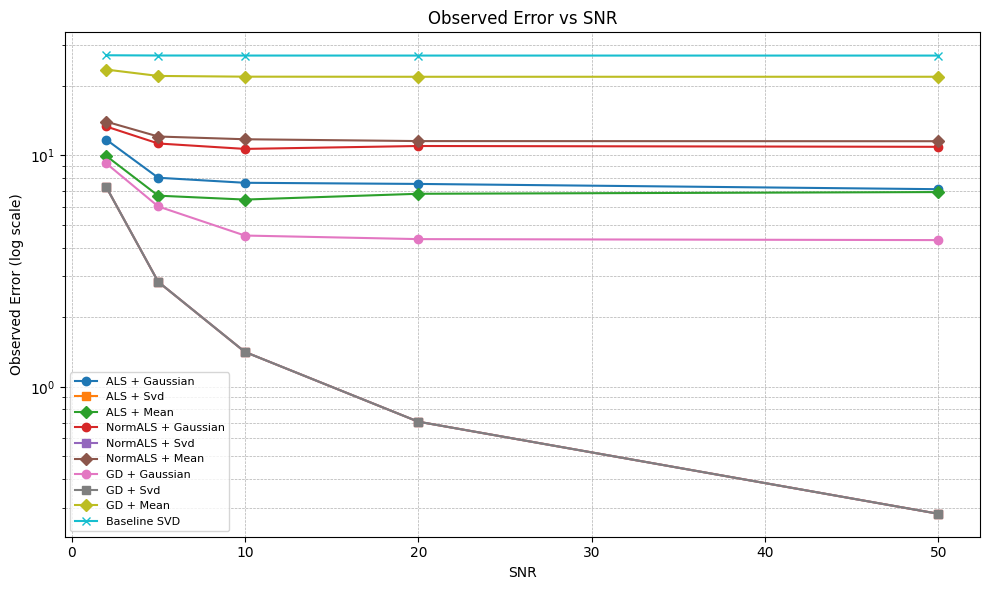

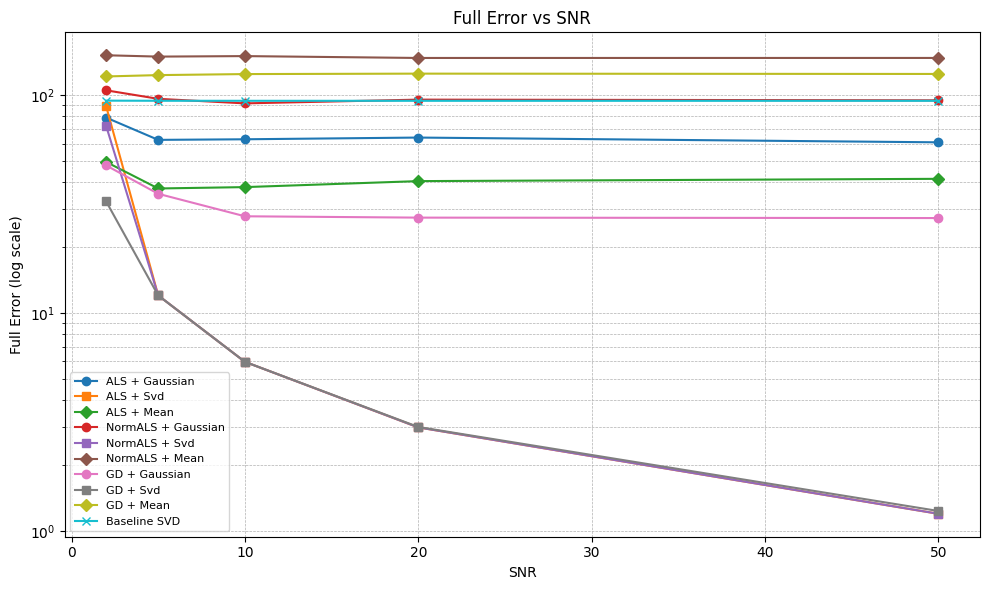

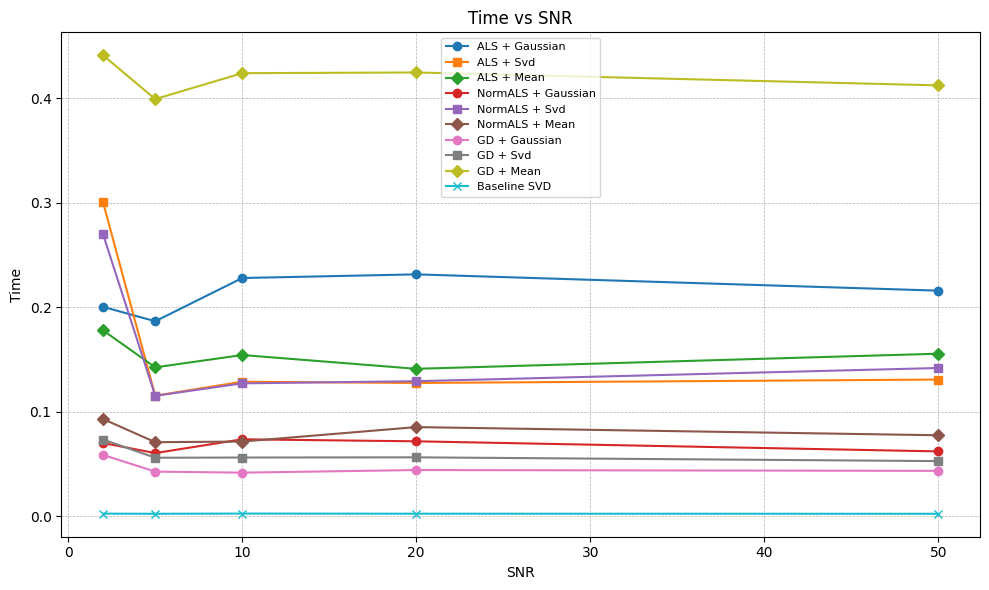

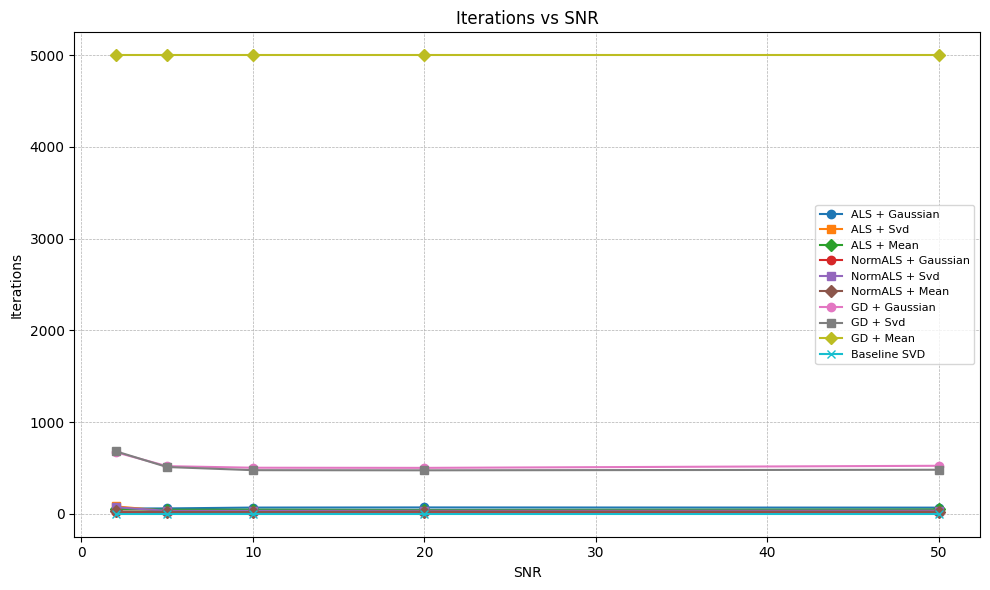

In [14]:
# === Plot each metric vs SNR ===
for metric_name, suffix in metrics.items():
    metric_data = defaultdict(list)

    for snr in snrs:
        for solver in solvers:
            if solver == 'Baseline SVD':
                key = f"{solver}"
                try:
                    value = np.mean(accum_results[snr][solver][f"{solver}_{suffix}"])
                    metric_data[key].append(value)
                except KeyError:
                    pass
            else:
                for method in methods:
                    key = f"{solver} + {method}"
                    try:
                        value = np.mean(accum_results[snr][method][f"{solver}_{suffix}"])
                        metric_data[key].append(value)
                    except KeyError:
                        pass

    # === Plot ===
    plt.figure(figsize=(10, 6))
    for label, values in metric_data.items():
        method = label.split(' + ')[-1]
        marker = method_markers.get(method, 'x')
        plt.plot(snrs, values, marker=marker, label=label)

    plt.xlabel('SNR')
    plt.ylabel(metric_name + (' (log scale)' if 'Error' in metric_name else ''))
    plt.title(f'{metric_name} vs SNR')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    if 'Error' in metric_name:
        plt.yscale('log')
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'{suffix}_vs_snr.pdf')
    plt.show()
